## 数据准备

In [1]:
from ginkgo.data import *
import numpy as np

In [2]:
stock_list = get_stockinfos()

没有缓存，重新计算并缓存


🗿 Got 5375 records about StockInfo from mysql.

In [3]:
stock_code = "000002.SZ"
stock_info = stock_list[stock_list["code"]==stock_code]
display(stock_info)

,code,code_name,industry,currency,market,list_date,delist_date,uuid,meta,desc,create_at,update_at,is_del,source
268,000002.SZ,万科A,全国地产,CURRENCY_TYPES.CNY,MARKET_TYPES.CHINA,1991-01-29,2100-01-01,0dd3cddd92c246698ed3f6aa5b1521f0,{},"This man is lazy, there is no description.",2024-12-04 17:33:10,2024-12-09 00:17:25,False,SOURCE_TYPES.TUSHARE


### 数据跨度

In [4]:
start_date = "2000-01-01"
end_date = "2025-01-01"

In [5]:
bar_data_raw = get_bars(code=stock_code, start_date=start_date, end_date=end_date, as_dataframe=True)
display(bar_data_raw.head(2))
bar_data_raw.describe()

,code,open,high,low,close,volume,amount,frequency,uuid,meta,desc,timestamp,source
0,000002.SZ,9.80,10.40,9.6,10.30,45747,46053.45,FREQUENCY_TYPES.DAY,4413c7238c5a44d08061fea0852f2369,{}                                            ...,"This man is lazy, there is no description.    ...",2000-01-04,SOURCE_TYPES.DATABASE
1,000002.SZ,10.35,10.45,10.0,10.04,46137,47348.00,FREQUENCY_TYPES.DAY,a4ecc6096037411281e04e2a5db1dafa,{}                                            ...,"This man is lazy, there is no description.    ...",2000-01-05,SOURCE_TYPES.DATABASE


,open,high,low,close,volume,amount,timestamp
count,5845.000000,5845.000000,5845.000000,5845.000000,5.845000e+03,5.845000e+03,5845
mean,14.630479,14.906712,14.389321,14.647902,7.818154e+05,1.154262e+06,2012-07-08 08:42:32.335329536
min,3.140000,3.200000,3.120000,3.140000,2.334000e+03,2.566000e+03,2000-01-04 00:00:00
25%,8.250000,8.380000,8.140000,8.270000,2.467280e+05,2.164410e+05,2006-04-11 00:00:00
50%,12.300000,12.520000,12.100000,12.300000,5.767120e+05,7.976183e+05,2012-05-15 00:00:00
75%,20.430000,20.730000,20.110000,20.500000,9.688210e+05,1.593419e+06,2018-12-21 00:00:00
max,41.120000,42.240000,40.460000,41.130000,1.097234e+07,2.010649e+07,2024-12-31 00:00:00
std,8.082726,8.247040,7.942681,8.093063,8.785911e+05,1.327240e+06,NaN


In [6]:
bar_data_raw.isnull().sum()

### 数据清洗

# Clean abnormal open
bar_data_raw = bar_data_raw[bar_data_raw['open'] > 0]

# Clean abnormal high
bar_data_raw = bar_data_raw[bar_data_raw['high'] > 0]

# Clean abnormal low
bar_data_raw = bar_data_raw[bar_data_raw['low'] > 0]

# Clean abnormal close
bar_data_raw = bar_data_raw[bar_data_raw['close'] > 0]

# Clean abnormal volume
bar_data_raw = bar_data_raw[bar_data_raw['volume'] > 0]

# Clean abnormal amount
bar_data_raw = bar_data_raw[bar_data_raw['amount'] > 0]

In [7]:
print(bar_data_raw.columns)

Index(['code', 'open', 'high', 'low', 'close', 'volume', 'amount', 'frequency',
       'uuid', 'meta', 'desc', 'timestamp', 'source'],
      dtype='object')


### 添加特征

In [8]:
bar_data = bar_data_raw.copy()
# remove null line
bar_data = bar_data.dropna().reset_index(drop=True).copy()
bar_data.describe()

,open,high,low,close,volume,amount,timestamp
count,5845.000000,5845.000000,5845.000000,5845.000000,5.845000e+03,5.845000e+03,5845
mean,14.630479,14.906712,14.389321,14.647902,7.818154e+05,1.154262e+06,2012-07-08 08:42:32.335329536
min,3.140000,3.200000,3.120000,3.140000,2.334000e+03,2.566000e+03,2000-01-04 00:00:00
25%,8.250000,8.380000,8.140000,8.270000,2.467280e+05,2.164410e+05,2006-04-11 00:00:00
50%,12.300000,12.520000,12.100000,12.300000,5.767120e+05,7.976183e+05,2012-05-15 00:00:00
75%,20.430000,20.730000,20.110000,20.500000,9.688210e+05,1.593419e+06,2018-12-21 00:00:00
max,41.120000,42.240000,40.460000,41.130000,1.097234e+07,2.010649e+07,2024-12-31 00:00:00
std,8.082726,8.247040,7.942681,8.093063,8.785911e+05,1.327240e+06,NaN


In [9]:
# remove columns
feature_columns = ['open', 'high', 'low', 'close', 'volume', 'amount']

bar_data = bar_data_raw[feature_columns].copy()
print(bar_data.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'amount'], dtype='object')


#### 预测目标

In [10]:
# add target, y in predict
target_span = 5
bar_data.loc[:, 'target'] = (bar_data['close'].shift(-target_span) - bar_data['close']) / bar_data['close']

In [11]:
display(bar_data)

,open,high,low,close,volume,amount,target
0,9.80,10.40,9.60,10.30,45747,46053.45,0.052427
1,10.35,10.45,10.00,10.04,46137,47348.00,0.041833
2,10.00,10.60,9.85,10.51,71920,74244.34,-0.006660
3,10.58,11.00,10.46,10.99,136349,147505.74,-0.087352
4,10.68,11.44,10.55,11.44,142425,159259.05,-0.094406
...,...,...,...,...,...,...,...
5840,7.71,7.73,7.47,7.54,1517662,1146549.84,NaN
5841,7.50,7.56,7.48,7.51,710188,534064.46,NaN
5842,7.51,7.63,7.49,7.55,1004323,760189.35,NaN
5843,7.50,7.51,7.33,7.36,1338890,990277.59,NaN


#### 其他特征

In [12]:
# 涨跌幅
return_spans = [1,2,3,4,5,6,7,8,9,10]
for i in return_spans:
    bar_data.loc[:, f'return_{i}d'] = (bar_data['close'] - bar_data['open'].shift(i)) / bar_data['open']

In [13]:
# 高低价波动幅度
bar_data.loc[:,'hl_range'] = (bar_data['high'] - bar_data['low'])/bar_data['low']

In [14]:
# 收盘价相对最高最低值的位置
position_spans = [1,2,3,4,5,6,7,8,9,10]
for i in position_spans:
    bar_data.loc[:,f'close_position_{i}d'] = (bar_data['close'] - bar_data['low'])/(bar_data['high'].shift(i) - bar_data['low'].shift(i))

In [15]:
# 成交量变化率
bar_data.loc[:,'volume_change'] = bar_data['volume'] / bar_data['volume'].shift(1) - 1

In [16]:
# 成交额变化率
bar_data.loc[:,'amount_change'] = bar_data['amount'] / bar_data['amount'].shift(1) - 1

In [17]:
# 成交量均值
volume_spans = [2,3,4,5,6,7,8,9, 10, 15, 18,20]
for i in volume_spans:
    bar_data.loc[:,f'volume_ma{i}'] = bar_data['volume'].rolling(window=i).mean()

In [18]:
# 波动率
volatility_spans = [2,3,4,5,6,7,8,9, 10, 15, 18,20]
for i in volatility_spans:
    bar_data.loc[:,f'volatility_{i}d'] = bar_data['close'].rolling(window=i).std()

#### 移出缺失值

In [19]:
bar_data = bar_data.replace([np.inf, -np.inf], np.nan)

In [20]:
bar_data = bar_data.dropna().reset_index(drop=True).copy()

In [21]:
bar_data.describe()

,open,high,low,close,volume,amount,target,return_1d,return_2d,return_3d,...,volatility_4d,volatility_5d,volatility_6d,volatility_7d,volatility_8d,volatility_9d,volatility_10d,volatility_15d,volatility_18d,volatility_20d
count,5790.000000,5790.000000,5790.000000,5790.000000,5.790000e+03,5.790000e+03,5790.000000,5790.000000,5790.000000,5790.000000,...,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000
mean,14.633287,14.908627,14.392877,14.650748,7.774652e+05,1.145662e+06,0.001890,0.001010,0.000478,-0.000025,...,0.287166,0.320923,0.351246,0.378797,0.404331,0.428194,0.450630,0.549339,0.601252,0.633272
std,8.103962,8.268417,7.963929,8.114387,8.672673e+05,1.296464e+06,0.063627,0.040164,0.051129,0.060069,...,0.319906,0.343966,0.367511,0.389969,0.411026,0.430830,0.449380,0.529952,0.571174,0.595788
min,3.140000,3.200000,3.120000,3.140000,2.334000e+03,2.566000e+03,-0.512391,-0.995683,-1.020619,-1.027982,...,0.005000,0.005477,0.008367,0.019024,0.025495,0.030732,0.030912,0.038073,0.045532,0.057956
25%,8.240000,8.370000,8.130000,8.250000,2.485238e+05,2.197768e+05,-0.030303,-0.017216,-0.022071,-0.026664,...,0.103441,0.120561,0.133432,0.143800,0.153210,0.161783,0.170639,0.215907,0.237839,0.253191
50%,12.310000,12.535000,12.115000,12.310000,5.755410e+05,7.956005e+05,-0.000792,-0.001100,-0.001129,-0.001181,...,0.180970,0.204181,0.228170,0.248759,0.267894,0.282951,0.302806,0.359057,0.397781,0.423071
75%,20.485000,20.747500,20.135000,20.500000,9.622688e+05,1.586791e+06,0.031405,0.018805,0.023721,0.028247,...,0.354812,0.395351,0.432120,0.458165,0.493672,0.528429,0.562606,0.681516,0.761719,0.811115
max,41.120000,42.240000,40.460000,41.130000,1.097234e+07,1.381880e+07,0.457865,0.194844,0.257202,0.295603,...,4.302488,3.994650,3.823212,3.749633,3.910141,4.114000,4.351486,4.658534,4.708030,4.760656


In [22]:
print(bar_data.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'amount', 'target',
       'return_1d', 'return_2d', 'return_3d', 'return_4d', 'return_5d',
       'return_6d', 'return_7d', 'return_8d', 'return_9d', 'return_10d',
       'hl_range', 'close_position_1d', 'close_position_2d',
       'close_position_3d', 'close_position_4d', 'close_position_5d',
       'close_position_6d', 'close_position_7d', 'close_position_8d',
       'close_position_9d', 'close_position_10d', 'volume_change',
       'amount_change', 'volume_ma2', 'volume_ma3', 'volume_ma4', 'volume_ma5',
       'volume_ma6', 'volume_ma7', 'volume_ma8', 'volume_ma9', 'volume_ma10',
       'volume_ma15', 'volume_ma18', 'volume_ma20', 'volatility_2d',
       'volatility_3d', 'volatility_4d', 'volatility_5d', 'volatility_6d',
       'volatility_7d', 'volatility_8d', 'volatility_9d', 'volatility_10d',
       'volatility_15d', 'volatility_18d', 'volatility_20d'],
      dtype='object')


## 训练集划分

In [23]:
from sklearn.model_selection import train_test_split
y = bar_data['target'].copy()
x = bar_data.drop(columns=['target']).copy()
# 标准化
def prepare_data():
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    return x_train, x_test, y_train, y_test

## 真实值与预测值评估方法

In [24]:
import matplotlib.pyplot as plt

def plot_scatter_with_line(y_test, y_test_pred):
    plt.figure(figsize=(10, 5))
    
    # 绘制散点图
    plt.scatter(y_test, y_test_pred, alpha=0.5, label="Truth : Predict")
    
    # 绘制理想的 y=x 线
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    
    plt.xlabel("Truth")
    plt.ylabel("Predict")
    plt.legend()
    plt.title("Result")
    plt.show()

import seaborn as sns

def plot_distribution(y_train, y_test_pred):
    plt.figure(figsize=(10, 5))

    # 查看真实值 y_train 的分布
    sns.histplot(y_train, kde=True, label="y_train", color='blue', alpha=0.5)

    # 查看预测值 y_test_pred 的分布
    sns.histplot(y_test_pred, kde=True, label="y_test_pred", color='red', alpha=0.5)

    plt.legend()
    plt.title("Distribution of y_train vs y_test_pred")
    plt.show()

## 随机森林

In [25]:
# 初始化随机森林回归模型
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# TODO 特征工程

x_train, x_test, y_train, y_test = prepare_data()
param_grid = {
    'n_estimators': [100, 200, 300],        # 树的数量
    'max_depth': [10, 15, 20],       # 最大深度
    'min_samples_split': [5, 10, 20],       # 每个节点最小样本数
    'min_samples_leaf': [2, 5, 10],         # 叶子节点最小样本数
    'max_features': ['sqrt', 'log2'], # 每棵树使用的特征数
}

rf_model = RandomForestRegressor(random_state=42)
# 使用GridSearchCV进行超参数搜索
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')
# 训练模型
grid_search.fit(x_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")

best_rf_model = grid_search.best_estimator_

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


训练集 MSE: 0.00146, R²: 0.65563
测试集 MSE: 0.00282, R²: 0.13854


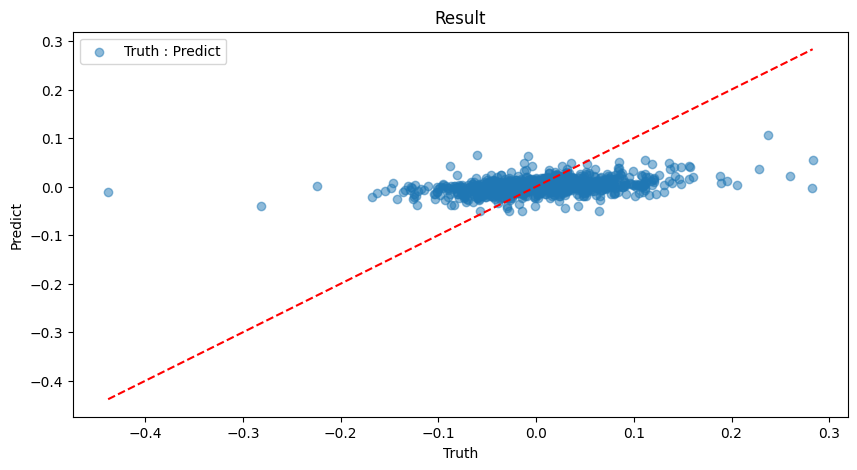

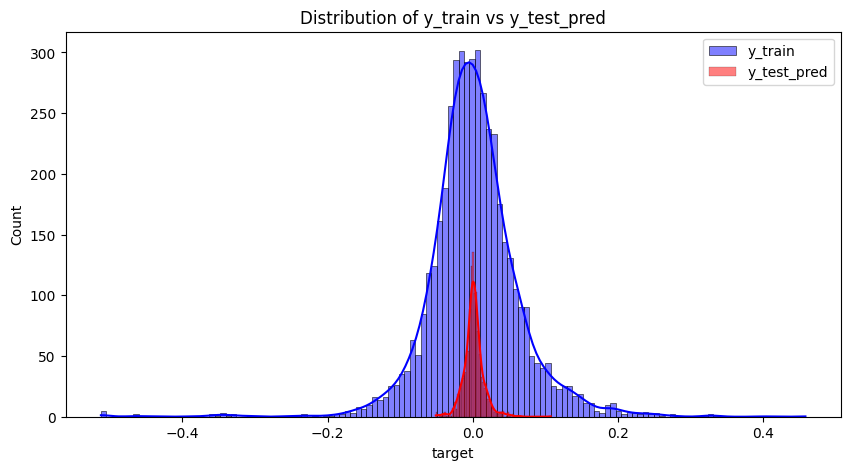

In [27]:
from sklearn.metrics import mean_squared_error, r2_score

# 训练集预测
y_train_pred = best_rf_model.predict(x_train)

# 测试集预测
y_test_pred = best_rf_model.predict(x_test)

# 计算均方误差 (MSE)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# 计算决定系数 (R²)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"训练集 MSE: {train_mse:.5f}, R²: {train_r2:.5f}")
print(f"测试集 MSE: {test_mse:.5f}, R²: {test_r2:.5f}")
plot_scatter_with_line(y_test, y_test_pred)
plot_distribution(y_train, y_test_pred)

In [ ]:
# 评估模型准确
plot_scatter_with_line(y_test, y_test_pred)
plot_distribution(y_train, y_test_pred)